## Harjoitustyö



In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np


In [3]:
!pip install scrapy

/opt/conda/lib/python3.7/site-packages/secretstorage/dhcrypto.py:16: CryptographyDeprecationWarning: int_from_bytes is deprecated, use int.from_bytes instead
  from cryptography.utils import int_from_bytes
/opt/conda/lib/python3.7/site-packages/secretstorage/util.py:25: CryptographyDeprecationWarning: int_from_bytes is deprecated, use int.from_bytes instead
  from cryptography.utils import int_from_bytes
  Using cached Scrapy-2.5.0-py2.py3-none-any.whl (254 kB)
Processing /root/.cache/pip/wheels/dc/d0/bf/0cc715c01fce0bace63b46283acf5cc630d5e5dbb4602c54e5/PyDispatcher-2.0.5-py3-none-any.whl
  Using cached zope.interface-5.4.0-cp37-cp37m-manylinux2010_x86_64.whl (251 kB)
Processing /root/.cache/pip/wheels/ca/44/01/3592ccfbcfaee4ab297c4097e6e9dbe1c7697e3531a39877ab/Protego-0.1.16-py3-none-any.whl
  Using cached w3lib-1.22.0-py2.py3-none-any.whl (20 kB)
  Using cached service_identity-18.1.0-py2.py3-none-any.whl (11 kB)
  Using cached itemadapter-0.2.0-py3-none-any.whl (9.3 kB)
  Using cac

In [2]:
!scrapy genspider etuovi_scraper etuovi.com

/root/joda/etuovi_scraper.py already exists


In [59]:
## lopullinen raapija

import scrapy
# raapija, joka kerää etuovi.com:sta ilmoituksien tiedoista
# asuntotyypin, osoitteen, hinnan, valmistuvuoden ja pinta-alan.
# (Kyseessä Tampereen omakotitalot)
class EtuoviScraperSpider(scrapy.Spider):
    name = 'etuovi_scraper'
    allowed_domains = ['etuovi.com']
    # assing a page url below
    start_urls = \
    ['https://www.etuovi.com/myytavat-asunnot?haku=M1644983732&sivu=0']

  # Funkito parse(self, response) käy läpi aloitusosoitteesta eteenpäin
  # sivuja, joilta dataa kerätään. Parse kutsuu parse_page-funktiota, jossa
  # on määritelty varsinainen kerättävä tieto.
  # max 5 sivua tässä esimerkissä
    def parse(self, response):
        for i in range(1, 21):
            url=response.request.url[:-1]+str(i)
            yield scrapy.Request(url, callback=self.parse_page)
        
    
    def parse_page(self, response):
        description_texts = response.css(\
          '[class="flexboxgrid__col-xs-12__1I1LS"] *::text').extract()
        size_text = response.css(\
          '[class="flexboxgrid__col-xs__26GXk flexboxgrid__col-md-4__2DYW-"] > span::text').extract()
        year_text = response.css(\
          '[class="flexboxgrid__col-xs-3__3Kf8r flexboxgrid__col-md-4__2DYW-"] > span::text'\
          ).extract()
        price_text = response.css(\
          '[class="flexboxgrid__col-xs-4__p2Lev flexboxgrid__col-md-4__2DYW-"] > span::text'\
          ).extract()

        for i in range(len(price_text)):
            yield {
                'house_type' : description_texts[2*i],
                'address': description_texts[2*i+1],
                'price': price_text[i],
                'year': year_text[i],
                'size': size_text[i]
            }

In [4]:
!scrapy runspider etuovi_scraper.py -o TreTurkuJklOulu.json

2021-04-27 18:24:03 [scrapy.utils.log] INFO: Scrapy 2.5.0 started (bot: scrapybot)
2021-04-27 18:24:03 [scrapy.utils.log] INFO: Versions: lxml 4.6.3.0, libxml2 2.9.10, cssselect 1.1.0, parsel 1.6.0, w3lib 1.22.0, Twisted 21.2.0, Python 3.7.10 (default, Feb 26 2021, 18:47:35) - [GCC 7.3.0], pyOpenSSL 19.1.0 (OpenSSL 1.1.1k  25 Mar 2021), cryptography 3.4.7, Platform Linux-4.14.225-169.362.amzn2.x86_64-x86_64-with-debian-10.6
2021-04-27 18:24:03 [scrapy.utils.log] DEBUG: Using reactor: twisted.internet.epollreactor.EPollReactor
2021-04-27 18:24:03 [scrapy.crawler] INFO: Overridden settings:
{'SPIDER_LOADER_WARN_ONLY': True}
2021-04-27 18:24:03 [scrapy.extensions.telnet] INFO: Telnet Password: 96d63d716a85eefc
2021-04-27 18:24:03 [scrapy.middleware] INFO: Enabled extensions:
['scrapy.extensions.corestats.CoreStats',
 'scrapy.extensions.telnet.TelnetConsole',
 'scrapy.extensions.memusage.MemoryUsage',
 'scrapy.extensions.feedexport.FeedExporter',
 'scrapy.extensions.logstats.LogStats']
202

In [29]:
!git commit -m "data collection modified, data cleaning and visualization added"

[master 78d89c4] data collection modified, data cleaning and visualization added
 1 file changed, 2072 insertions(+), 135 deletions(-)


In [28]:
!git add 'joda_ht.ipynb'

In [2]:
!git config --global user.email "sara.paukkeri@hotmail.com"

## Datan siivoaminen ja piirteiden  muokkaus

In [5]:
import json

In [6]:
# read out.json file to d
d = open('TreTurkuJklOulu.json')
#d = open('out2.json') #whole dataset
data = json.load(d)
d.close()
data[0:1]

[{'house_type': 'Erillistalo | 5h + k + s',
  'address': 'Kirkkosalmenkaarre 18 A 3, Oulunsalo, Oulu',
  'price': '236\xa0400\xa0€',
  'year': '2021',
  'size': '105 m²'}]

In [7]:
# convert array to dataframe
df = pd.DataFrame(data)
df.head()

,house_type,address,price,year,size
0,Erillistalo | 5h + k + s,"Kirkkosalmenkaarre 18 A 3, Oulunsalo, Oulu",236 400 €,2021,105 m²
1,"Omakotitalo | 4h, k, kh. 3h, k, kh. 2x2h, k, k...","Puolangantie 554, Ylikiiminki, Oulu",149 000 €,1952,430 / 522 m²
2,Omakotitalo | 3H + K + KPH + S + Aula + Takkah...,"Sepänkuja 8, Kiiminki, Oulu",129 000 €,1976,120 / 150 m²
3,Omakotitalo | 4h + k + sa + tuulikaappi + at,"Taurinkuja 21, Peltola, Oulu",179 000 €,-,109 / 144 m²
4,"Omakotitalo | 3-4h, k, kph, s","Hietatie 34, Keljonkangas, Jyväskylä",139 000 €,1963,96 / 130 m²


In [9]:
df.head(50)

,house_type,address,price,year,size
0,Erillistalo | 5h + k + s,"Kirkkosalmenkaarre 18 A 3, Oulunsalo, Oulu",236 400 €,2021,105 m²
1,"Omakotitalo | 4h, k, kh. 3h, k, kh. 2x2h, k, k...","Puolangantie 554, Ylikiiminki, Oulu",149 000 €,1952,430 / 522 m²
2,Omakotitalo | 3H + K + KPH + S + Aula + Takkah...,"Sepänkuja 8, Kiiminki, Oulu",129 000 €,1976,120 / 150 m²
3,Omakotitalo | 4h + k + sa + tuulikaappi + at,"Taurinkuja 21, Peltola, Oulu",179 000 €,-,109 / 144 m²
4,"Omakotitalo | 3-4h, k, kph, s","Hietatie 34, Keljonkangas, Jyväskylä",139 000 €,1963,96 / 130 m²
5,Erillistalo | 4mh + oh + k + khh + wc + ph + s,"Korttitie 20 B, Pateniemi, Oulu",420 000 €,2021,"110,5 / 119,5 m²"
6,"Erillistalo | 4h, k, khh, kph, s, 2wc","Soittajankuja 1 C 19, Soittajankangas, Oulu",262 900 €,2022,"102,5 m²"
7,Omakotitalo | 4h + k + aputilat ja 4 kpl 1h + kt,"Länsi-Päijänteentie 10, Keljo, Jyväskylä",265 000 €,1952,228 / 328 m²
8,"Omakotitalo | 4h, k, ph, s","Mekaanikonkuja 4, Tikkakoski, Jyväskylä",79 000 €,1963,100 / 128 m²
9,"Omakotitalo | Oh + k + 3mh + kph + 3xwc, takka...","Ristikorventie 3, Kotimäki,, Vaajakoski Jyväskylä",132 000 €,1950,112 / 150 m²


In [10]:
# split column size to size and living_space and remove "m2" and spaces
# add rows with empty values(="-") to remove
remove=[]



living_space=[]
for i in range(0, df['size'].size):
  
    if "/" in df['size'][i]: 
        sizes = df.loc[i,'size'].split("/")
        df.loc[i,'size'] = sizes[1].replace(" ", "").replace("m\u00b2","").replace(",",".").replace("\xa0", "")
        living_space.append(sizes[0].replace(" ", "").replace(",",".").replace("\xa0", ""))
    elif df['size'][i] != "-": #  only one size available
        df.loc[i,'size'] = df.loc[i,'size'].replace(" ", "").replace("m\u00b2","").replace(",",".").replace("\xa0", "")
        living_space.append(df.loc[i,'size'])
    else: # size is "-" or
        living_space.append(0)
        remove.append(i)
        df.loc[i,'size']=None

#df=df.dropna()
  
df['living_space']=living_space

df['size'] = df['size'].astype(float)
df.living_space = df.living_space.astype(float)

In [11]:
# remove € from price and set datatype to int
for i in range(0, df['price'].size): #=0; i < df.price.length; i++):
    #df['price'][i]=price.replace("-","")
    if float(df.loc[i,'price'].replace("\xa0", "").replace('€',"").replace(",","."))>=float(400000):#####################################
        remove.append(i)#####################################################
        df.loc[i,'price']=None######################
    elif (df.loc[i,'price']=='-') and (i not in remove):
        remove.append(i)
        df.loc[i,'price']=None
    else: 
        df.loc[i,'price'] = df.loc[i,'price'].replace("\xa0", "").replace('€',"").replace(",",".")
        
#df=df.dropna()

df['price'] = df['price'].astype(float)

In [12]:
df.head()

,house_type,address,price,year,size,living_space
0,Erillistalo | 5h + k + s,"Kirkkosalmenkaarre 18 A 3, Oulunsalo, Oulu",236400.0,2021,105.0,105.0
1,"Omakotitalo | 4h, k, kh. 3h, k, kh. 2x2h, k, k...","Puolangantie 554, Ylikiiminki, Oulu",149000.0,1952,522.0,430.0
2,Omakotitalo | 3H + K + KPH + S + Aula + Takkah...,"Sepänkuja 8, Kiiminki, Oulu",129000.0,1976,150.0,120.0
3,Omakotitalo | 4h + k + sa + tuulikaappi + at,"Taurinkuja 21, Peltola, Oulu",179000.0,-,144.0,109.0
4,"Omakotitalo | 3-4h, k, kph, s","Hietatie 34, Keljonkangas, Jyväskylä",139000.0,1963,130.0,96.0


In [13]:
# Split address to address, region, area
area=[]
city=[]

for i in range(0, df['address'].size):
    add = df.loc[i,'address'].split(", ")
    df.loc[i,'address'] = add[0]
    if len(add) < 3:
        add2 = add[1].split(" ")
        if len(add2) < 2:
            city.append(add2[0])
            area.append(add2[0])
        else:
            city.append(add2[1])
            area.append(add2[0])
    else:
        area.append(add[1])
        city.append(add[2])
  
df['area']=area
df['city'] = city

In [14]:
rooms=[]

for i in range(0, df['house_type'].size):
    house = df.loc[i,'house_type'].split(" | ")
    if len(house) < 2: #only another information available
        df.loc[i,'house_type'] = house[0]
        rooms.append(house[0])
    else:
        df.loc[i,'house_type'] = house[0]
        rooms.append(house[1])
  
df['rooms']=rooms

In [15]:
for i in range(0, df.year.size):
    if df.loc[i,'year']=="-" and i not in remove:
        remove.append(i)

df = df.drop(remove)

df['year'] = df['year'].astype(int)

In [16]:
df.head()

,house_type,address,price,year,size,living_space,area,city,rooms
0,Erillistalo,Kirkkosalmenkaarre 18 A 3,236400.0,2021,105.0,105.0,Oulunsalo,Oulu,5h + k + s
1,Omakotitalo,Puolangantie 554,149000.0,1952,522.0,430.0,Ylikiiminki,Oulu,"4h, k, kh. 3h, k, kh. 2x2h, k, kh. Kerhotila"
2,Omakotitalo,Sepänkuja 8,129000.0,1976,150.0,120.0,Kiiminki,Oulu,3H + K + KPH + S + Aula + Takkahuone + VH + Va...
4,Omakotitalo,Hietatie 34,139000.0,1963,130.0,96.0,Keljonkangas,Jyväskylä,"3-4h, k, kph, s"
6,Erillistalo,Soittajankuja 1 C 19,262900.0,2022,102.5,102.5,Soittajankangas,Oulu,"4h, k, khh, kph, s, 2wc"


Muokataan osoite koordinaateiksi

In [14]:
!pip install geopy

/opt/conda/lib/python3.7/site-packages/secretstorage/dhcrypto.py:16: CryptographyDeprecationWarning: int_from_bytes is deprecated, use int.from_bytes instead
  from cryptography.utils import int_from_bytes
/opt/conda/lib/python3.7/site-packages/secretstorage/util.py:25: CryptographyDeprecationWarning: int_from_bytes is deprecated, use int.from_bytes instead
  from cryptography.utils import int_from_bytes


In [17]:
# edit the address to a format suitable for the coordinate change
df['geo_address'] = df["address"]+ ", " + df["city"] + ", Finland"

from geopy.geocoders import Nominatim
geolocator = Nominatim(user_agent = "joda ht")


In [18]:
df["loc"] = df["geo_address"].apply(geolocator.geocode)
# select koordinates from loc
df["point"] = df["loc"].apply(lambda loc: tuple(loc.point) if loc else None)
#split coordinates to latitude, longitude and altitude
df[['lat', 'lon', 'altitude']] = pd.DataFrame(df['point'].to_list(), index=df.index)

In [19]:
df.head()

,house_type,address,price,year,size,living_space,area,city,rooms,geo_address,loc,point,lat,lon,altitude
0,Erillistalo,Kirkkosalmenkaarre 18 A 3,236400.0,2021,105.0,105.0,Oulunsalo,Oulu,5h + k + s,"Kirkkosalmenkaarre 18 A 3, Oulu, Finland","(Kirkkosalmenkaarre, Oulunsalo, Oulu, Oulun se...","(64.9293039, 25.4216705, 0.0)",64.929304,25.421671,0.0
1,Omakotitalo,Puolangantie 554,149000.0,1952,522.0,430.0,Ylikiiminki,Oulu,"4h, k, kh. 3h, k, kh. 2x2h, k, kh. Kerhotila","Puolangantie 554, Oulu, Finland","(Puolangantie, Jokela, Oulu, Oulun seutukunta,...","(64.9804365, 26.2247937, 0.0)",64.980436,26.224794,0.0
2,Omakotitalo,Sepänkuja 8,129000.0,1976,150.0,120.0,Kiiminki,Oulu,3H + K + KPH + S + Aula + Takkahuone + VH + Va...,"Sepänkuja 8, Oulu, Finland","(Sepänkuja, Raatinharju, Kolamäki, Kiiminki, O...","(65.1255237, 25.7875678, 0.0)",65.125524,25.787568,0.0
4,Omakotitalo,Hietatie 34,139000.0,1963,130.0,96.0,Keljonkangas,Jyväskylä,"3-4h, k, kph, s","Hietatie 34, Jyväskylä, Finland","(34, Hietatie, Keljonkangas, Jyväskylä, Jyväsk...","(62.190388049999996, 25.714925560192444, 0.0)",62.190388,25.714926,0.0
6,Erillistalo,Soittajankuja 1 C 19,262900.0,2022,102.5,102.5,Soittajankangas,Oulu,"4h, k, khh, kph, s, 2wc","Soittajankuja 1 C 19, Oulu, Finland",None,None,NaN,NaN,NaN


In [197]:
#df['loc'][0].address.split(",")[-2]

' 20400'

### Datan kuvaileminen

Text(0.5, 1.0, 'Living Space')

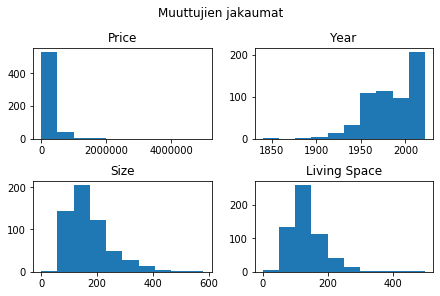

In [169]:
fig = plt.figure(constrained_layout=True)
gs = fig.add_gridspec(2, 2)
fig.suptitle('Muuttujien jakaumat')

f_ax1 = fig.add_subplot(gs[0, 0])
f_ax1.hist(df['price'])
f_ax1.set_title('Price')
f_ax2 = fig.add_subplot(gs[0, 1])
f_ax2.hist(df['year'])
f_ax2.set_title('Year')
f_ax3 = fig.add_subplot(gs[1, 0])
f_ax3.hist(df['size'])
f_ax3.set_title('Size')
f_ax4 = fig.add_subplot(gs[1, 1])
f_ax4.hist(df['living_space'])
f_ax4.set_title('Living Space')

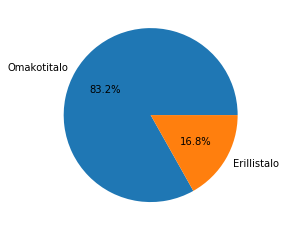

In [170]:
from collections import Counter

#type of houses in data
value = Counter(df['house_type']).values()
label = Counter(df['house_type']).keys()

plt.pie(value, labels = label, autopct='%1.1f%%')
plt.show()

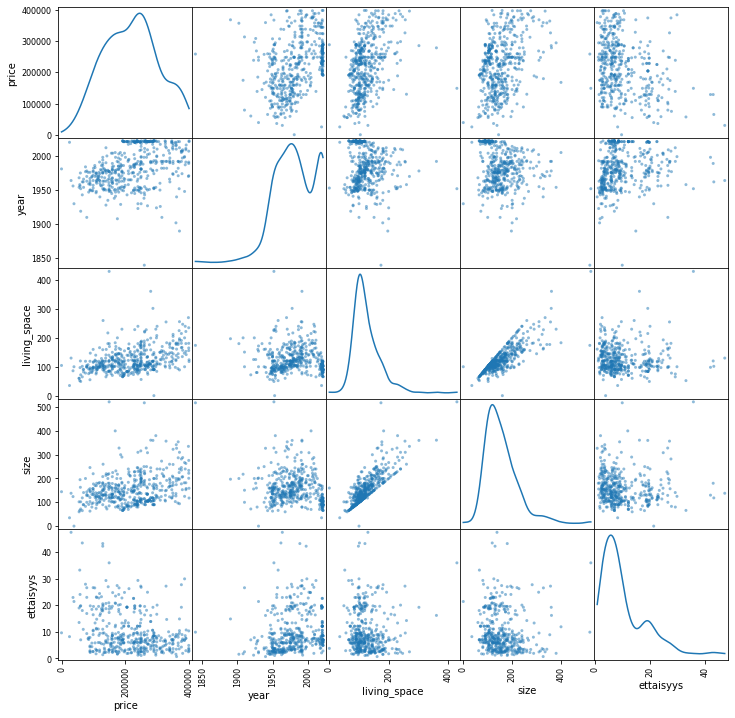

In [26]:
from pandas.plotting import scatter_matrix

# plot a scatter matrix to detect dependencies
df_int = df.loc[:,['price', 'year', 'living_space', 'size','ettaisyys']]

scatter_matrix(df_int, figsize=(12,12), diagonal="kde");

In [27]:
df.corr()

,price,year,size,living_space,lat,lon,altitude,ettaisyys
price,1.000000,0.380046,0.317230,0.400557,-0.274434,-0.205081,NaN,-0.309184
year,0.380046,1.000000,-0.254301,-0.093475,0.277426,0.216723,NaN,0.164222
size,0.317230,-0.254301,1.000000,0.821075,-0.198880,-0.063829,NaN,-0.060091
living_space,0.400557,-0.093475,0.821075,1.000000,-0.076373,0.027658,NaN,-0.019475
lat,-0.274434,0.277426,-0.198880,-0.076373,1.000000,0.718037,NaN,0.290339
lon,-0.205081,0.216723,-0.063829,0.027658,0.718037,1.000000,NaN,0.215400
altitude,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
ettaisyys,-0.309184,0.164222,-0.060091,-0.019475,0.290339,0.215400,NaN,1.000000


In [67]:
!pip install folium

/opt/conda/lib/python3.7/site-packages/secretstorage/dhcrypto.py:16: CryptographyDeprecationWarning: int_from_bytes is deprecated, use int.from_bytes instead
  from cryptography.utils import int_from_bytes
/opt/conda/lib/python3.7/site-packages/secretstorage/util.py:25: CryptographyDeprecationWarning: int_from_bytes is deprecated, use int.from_bytes instead
  from cryptography.utils import int_from_bytes
     |████████████████████████████████| 94 kB 464 kB/s eta 0:00:011


In [28]:
import folium
from folium.plugins import MarkerCluster

#Define coordinates of where we want to center our map
center = [61.6027417, 23.8721711]

#Create the map
my_map = folium.Map(location = center, zoom_start = 5)

# Add addresses to the map
for index, row in df.iterrows():
    if row.point != None:
        text ="Price: " + str(row.price) + " €" + "\n Size: " + str(row['size']) + " m2 " + "Address: " + row.address
        folium.Marker([row.lat,row.lon], popup = text).add_to(my_map)

#Display the map
my_map

### Koneoppiminen

In [20]:
from sklearn import preprocessing
from sklearn import linear_model
from sklearn.model_selection import cross_val_predict
from sklearn.impute import SimpleImputer
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score
from sklearn.model_selection import train_test_split
from sklearn.metrics import explained_variance_score

from sklearn.linear_model import LinearRegression # OLS algorithm
from sklearn.linear_model import Ridge # Ridge algorithm
from sklearn.linear_model import Lasso # Lasso algorithm
from sklearn.linear_model import BayesianRidge # Bayesian algorithm
from sklearn.linear_model import ElasticNet # ElasticNet algorithm
from sklearn.metrics import mean_absolute_error

from sklearn.metrics import r2_score # evaluation metric

import os

In [29]:
df.head()

,house_type,address,price,year,size,living_space,area,city,rooms,geo_address,loc,point,lat,lon,altitude,ettaisyys
0,Erillistalo,Kirkkosalmenkaarre 18 A 3,236400.0,2021,105.0,105.0,Oulunsalo,Oulu,5h + k + s,"Kirkkosalmenkaarre 18 A 3, Oulu, Finland","(Kirkkosalmenkaarre, Oulunsalo, Oulu, Oulun se...","(64.9293039, 25.4216705, 0.0)",64.929304,25.421671,0.0,9.666413
1,Omakotitalo,Puolangantie 554,149000.0,1952,522.0,430.0,Ylikiiminki,Oulu,"4h, k, kh. 3h, k, kh. 2x2h, k, kh. Kerhotila","Puolangantie 554, Oulu, Finland","(Puolangantie, Jokela, Oulu, Oulun seutukunta,...","(64.9804365, 26.2247937, 0.0)",64.980436,26.224794,0.0,35.883887
2,Omakotitalo,Sepänkuja 8,129000.0,1976,150.0,120.0,Kiiminki,Oulu,3H + K + KPH + S + Aula + Takkahuone + VH + Va...,"Sepänkuja 8, Oulu, Finland","(Sepänkuja, Raatinharju, Kolamäki, Kiiminki, O...","(65.1255237, 25.7875678, 0.0)",65.125524,25.787568,0.0,19.520298
4,Omakotitalo,Hietatie 34,139000.0,1963,130.0,96.0,Keljonkangas,Jyväskylä,"3-4h, k, kph, s","Hietatie 34, Jyväskylä, Finland","(34, Hietatie, Keljonkangas, Jyväskylä, Jyväsk...","(62.190388049999996, 25.714925560192444, 0.0)",62.190388,25.714926,0.0,5.933479
6,Erillistalo,Soittajankuja 1 C 19,262900.0,2022,102.5,102.5,Soittajankangas,Oulu,"4h, k, khh, kph, s, 2wc","Soittajankuja 1 C 19, Oulu, Finland",None,None,NaN,NaN,NaN,NaN


In [30]:
#select features
#0=house_type, 1=address 2=price, 3=year,
#4=size, 5=living_space, 6=area, 7=city
#15=distance

dfTrain = df.iloc[:,[0,2,3,5,7,15]]

In [31]:
dfTrain.head()

,house_type,price,year,living_space,city,ettaisyys
0,Erillistalo,236400.0,2021,105.0,Oulu,9.666413
1,Omakotitalo,149000.0,1952,430.0,Oulu,35.883887
2,Omakotitalo,129000.0,1976,120.0,Oulu,19.520298
4,Omakotitalo,139000.0,1963,96.0,Jyväskylä,5.933479
6,Erillistalo,262900.0,2022,102.5,Oulu,NaN


In [32]:
# Converting house_type and city attributes to categorical values.
le = preprocessing.LabelEncoder()

arr = le.fit_transform(dfTrain.house_type)
dfTrain['house_type'] = arr

arr = le.fit_transform(dfTrain.city)
dfTrain['city'] = arr


/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """
/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  


In [73]:
dfTrain.corr()
        

,house_type,price,year,living_space,city
house_type,1.000000,-0.082619,-0.551951,0.289775,-0.031467
price,-0.082619,1.000000,0.191510,0.168573,0.076331
year,-0.551951,0.191510,1.000000,-0.111195,-0.072860
living_space,0.289775,0.168573,-0.111195,1.000000,0.015028
city,-0.031467,0.076331,-0.072860,0.015028,1.000000


In [21]:

#Tampere Keskustori 1
#Turku eerikinkatu
#oulu kauppatori
#jyväskylä asema-aukio
j = {'Kaupunki': ['Tampere', 'Oulu', 'Jyväskylä', 'Turku'], 'Osoite': ['Keskustori 1, Tampere, Finland',  \
    'Kauppatori, Oulu, Finland', 'Asema-aukio, Jyväskylä, Finland', 'Eerikinkatu, Turku, Finland']}
etaisyyskesk = pd.DataFrame(j)



etaisyyskesk["loc"] = etaisyyskesk["Osoite"].apply(geolocator.geocode)
# select koordinates from loc
etaisyyskesk["point"] = etaisyyskesk["loc"].apply(lambda loc: tuple(loc.point) if loc else None)
#split coordinates to latitude, longitude and altitude
etaisyyskesk[['lat', 'lon', 'altitude']] = pd.DataFrame(etaisyyskesk["point"].to_list(), index=etaisyyskesk.index)

etaisyyskesk.head()

#etaisyyskesk['final'] = (etaisyyskesk['lat'], etaisyyskesk['lon'])




,Kaupunki,Osoite,loc,point,lat,lon,altitude
0,Tampere,"Keskustori 1, Tampere, Finland","(Keskustori I, Jugendtori, Tammerkoski, Ratina...","(61.4973936, 23.7607905, 0.0)",61.497394,23.760790,0.0
1,Oulu,"Kauppatori, Oulu, Finland","(Kauppatori, Kaarlenväylä, Ydinkeskusta, Pokki...","(65.0142385, 25.4654655, 0.0)",65.014239,25.465466,0.0
2,Jyväskylä,"Asema-aukio, Jyväskylä, Finland","(Asema-aukio, 1. kaupunginosa, Kantakaupunki, ...","(62.2412309, 25.7496762, 0.0)",62.241231,25.749676,0.0
3,Turku,"Eerikinkatu, Turku, Finland","(Eerikinkatu, Tervatori, VI, Keskusta, Turku, ...","(60.4534928, 22.2747381, 0.0)",60.453493,22.274738,0.0


In [24]:
etta = []
for index, row in df.iterrows():
    if 'Tampere' in row.city:
        if hs.haversine((etaisyyskesk['lat'][0],etaisyyskesk['lon'][0]),(row['lat'],row['lon'])) >200:
            etta.append(None)
        else:
            etta.append(hs.haversine((etaisyyskesk['lat'][0],etaisyyskesk['lon'][0]),(row['lat'],row['lon'])))
    elif 'Oulu' in row.city:
        if hs.haversine((etaisyyskesk['lat'][1],etaisyyskesk['lon'][1]),(row['lat'],row['lon'])) >200:
            etta.append(None)
        else:
            etta.append(hs.haversine((etaisyyskesk['lat'][1],etaisyyskesk['lon'][1]),(row['lat'],row['lon'])))
    elif 'Jyväskylä' in row.city:
        if hs.haversine((etaisyyskesk['lat'][2],etaisyyskesk['lon'][2]),(row['lat'],row['lon'])) >200:
            etta.append(None)
        else:
            etta.append(hs.haversine((etaisyyskesk['lat'][2],etaisyyskesk['lon'][2]),(row['lat'],row['lon'])))
    elif 'Turku' in row.city:
        if hs.haversine((etaisyyskesk['lat'][3],etaisyyskesk['lon'][3]),(row['lat'],row['lon'])) >200:
            etta.append(None)
        else:
            etta.append(hs.haversine((etaisyyskesk['lat'][3],etaisyyskesk['lon'][3]),(row['lat'],row['lon'])))
    else:
        etta.append(None)

df['ettaisyys']=etta

In [34]:
dfTrain.head()

,house_type,price,year,living_space,city,ettaisyys
0,0,236400.0,2021,105.0,17,9.666413
1,1,149000.0,1952,430.0,17,35.883887
2,1,129000.0,1976,120.0,17,19.520298
4,1,139000.0,1963,96.0,13,5.933479
6,0,262900.0,2022,102.5,17,NaN


In [35]:
#Data normalization: Min-Max-Scalar / RobustScaler
scaler = preprocessing.RobustScaler()
#scaler = preprocessing.MinMaxScaler() 


dfTrain = dfTrain.dropna()

dfTrain_x=dfTrain.iloc[:, [0,2,3,4,5]]####################################################dfTrain.iloc[:, [0,2,3,4]]
Train_x = pd.DataFrame(scaler.fit_transform(dfTrain_x))
Train_y = (dfTrain.iloc[:, [1]]*dfTrain.iloc[:, [1]]).astype(int)#####################tässä kerroin

In [78]:
print(dfTrain.corr())
print(Train_x.corr())

              house_type     price      year  living_space      city
house_type      1.000000 -0.082619 -0.551951      0.289775 -0.031467
price          -0.082619  1.000000  0.191510      0.168573  0.076331
year           -0.551951  0.191510  1.000000     -0.111195 -0.072860
living_space    0.289775  0.168573 -0.111195      1.000000  0.015028
city           -0.031467  0.076331 -0.072860      0.015028  1.000000
          0         1         2         3
0  1.000000 -0.551951  0.289775 -0.031467
1 -0.551951  1.000000 -0.111195 -0.072860
2  0.289775 -0.111195  1.000000  0.015028
3 -0.031467 -0.072860  0.015028  1.000000


In [185]:
# convert prices to 12 categories
# used with neural networks
"""encode=[]
Train_ye=np.array(Train_y)
for i in range(Train_ye.size):
    if Train_ye[i] <=100000:
        encode.append(0)
    elif Train_ye[i] <=150000:
        encode.append(1)
    elif Train_ye[i] <=200000:
        encode.append(2)
    elif Train_ye[i] <=250000:
        encode.append(3)
    elif Train_ye[i] <=300000:
        encode.append(4)
    elif Train_ye[i] <=350000:
        encode.append(5)
    elif Train_ye[i] <=400000:
        encode.append(6)
    elif Train_ye[i] <=450000:
        encode.append(7)
    elif Train_ye[i] <=500000:
        encode.append(8)
    elif Train_ye[i] <=550000:
        encode.append(9)
    elif Train_ye[i] <=600000:
        encode.append(10)
    elif Train_ye[i] <=650000:
        encode.append(5)
    elif Train_ye[i] <=700000:
        encode.append(6)
    elif Train_ye[i] <=750000:
        encode.append(7)
    elif Train_ye[i] <=800000:
        encode.append(8)
    elif Train_ye[i] <=850000:
        encode.append(9)
    elif Train_ye[i] <=900000:
        encode.append(10)
    else:
        encode.append(11)
    
print(encode[0:10])
arr = le.fit_transform(encode)
encode = arr"""

'encode=[]\nTrain_ye=np.array(Train_y)\nfor i in range(Train_ye.size):\n    if Train_ye[i] <=100:#000:\n        encode.append(0)\n    elif Train_ye[i] <=150:#000:\n        encode.append(1)\n    elif Train_ye[i] <=200:#000:\n        encode.append(2)\n    elif Train_ye[i] <=250:#000:\n        encode.append(3)\n    elif Train_ye[i] <=300:#000:\n        encode.append(4)\n    elif Train_ye[i] <=350:#000:\n        encode.append(5)\n    elif Train_ye[i] <=400:#000:\n        encode.append(6)\n    elif Train_ye[i] <=450:#000:\n        encode.append(7)\n    elif Train_ye[i] <=500:#000:\n        encode.append(8)\n    elif Train_ye[i] <=550:#000:\n        encode.append(9)\n    elif Train_ye[i] <=600:#000:\n        encode.append(10)\n    elif Train_ye[i] <=650:#000:\n        encode.append(5)\n    elif Train_ye[i] <=700:#000:\n        encode.append(6)\n    elif Train_ye[i] <=750:#000:\n        encode.append(7)\n    elif Train_ye[i] <=800:#000:\n        encode.append(8)\n    elif Train_ye[i] <=850:#0

In [182]:
Train_x.shape

(576, 4)

In [36]:
#Logistic Regression

X_train, X_test, y_train, y_test = train_test_split(Train_x, np.array(Train_y).ravel(), test_size=0.2, random_state=13)

for i in range(1, 300, 50):
    reg = LogisticRegression(max_iter=i).fit(X_train, y_train)
    predicted_y =reg.predict(X_test)
    print('Iterations: {} Explained Variance Score: {}'.format(i, explained_variance_score(y_test, predicted_y)))


/opt/conda/lib/python3.7/site-packages/sklearn/linear_model/_logistic.py:940: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  extra_warning_msg=_LOGISTIC_SOLVER_CONVERGENCE_MSG)


Iterations: 1 Explained Variance Score: 0.533121365101461
Iterations: 51 Explained Variance Score: 0.5906976739454557
Iterations: 101 Explained Variance Score: 0.5906976739454557
Iterations: 151 Explained Variance Score: 0.5906976739454557
Iterations: 201 Explained Variance Score: 0.5906976739454557
Iterations: 251 Explained Variance Score: 0.5906976739454557


In [37]:
#Gradient Boosting Regressor
from sklearn import ensemble

gbr = ensemble.GradientBoostingRegressor(n_estimators = 4, max_depth = 5, min_samples_split=2, learning_rate=0.01, loss='ls')
gbr.fit(X_train, y_train)
explained_variance_score(y_test, gbr.predict(X_test))


0.04398356615592769

In [38]:
# 1. Ridge
ridge = Ridge(alpha = 0.5)
ridge.fit(X_train, y_train)
ridge_yhat = ridge.predict(X_test)

# 2. Lasso
lasso = Lasso(alpha = 0.01)
lasso.fit(X_train, y_train)
lasso_yhat = lasso.predict(X_test)

# 3. Bayesian
bayesian = BayesianRidge()
bayesian.fit(X_train, y_train)
bayesian_yhat = bayesian.predict(X_test)

# 4. ElasticNet
en = ElasticNet(alpha = 0.01)
en.fit(X_train, y_train)
en_yhat = en.predict(X_test)

In [39]:
print('Explained Variance Score of Ridge model is {}'.format(explained_variance_score(y_test, ridge_yhat)))

print('Explained Variance Score of Lasso model is {}'.format(explained_variance_score(y_test, lasso_yhat)))

print('Explained Variance Score of Bayesian model is {}'.format(explained_variance_score(y_test, bayesian_yhat)))

print('Explained Variance Score of ElasticNet is {}'.format(explained_variance_score(y_test, en_yhat)))

Explained Variance Score of Ridge model is 0.5137556397678156
Explained Variance Score of Lasso model is 0.5130165994823991
Explained Variance Score of Bayesian model is 1.1102230246251565e-16
Explained Variance Score of ElasticNet is 0.5153951535253655


Epoch 1/20
11/11 [==============================] - 1s 29ms/step - loss: 4889083736275398164480.0000 - accuracy: 0.0000e+00 - val_loss: 4190862632371470991360.0000 - val_accuracy: 0.0000e+00
Epoch 2/20
11/11 [==============================] - 0s 5ms/step - loss: 4675631057967801434112.0000 - accuracy: 0.0042 - val_loss: 4190862632371470991360.0000 - val_accuracy: 0.0000e+00
Epoch 3/20
11/11 [==============================] - 0s 5ms/step - loss: 4549813080384277577728.0000 - accuracy: 0.0055 - val_loss: 4190862632371470991360.0000 - val_accuracy: 0.0000e+00
Epoch 4/20
11/11 [==============================] - 0s 8ms/step - loss: 4760893487588156899328.0000 - accuracy: 7.4491e-04 - val_loss: 4190862632371470991360.0000 - val_accuracy: 0.0000e+00
Epoch 5/20
11/11 [==============================] - 0s 9ms/step - loss: 4683168840562872680448.0000 - accuracy: 0.0033 - val_loss: 4190862632371470991360.0000 - val_accuracy: 0.0000e+00
Epoch 6/20
11/11 [==============================] - 0s 5ms/st

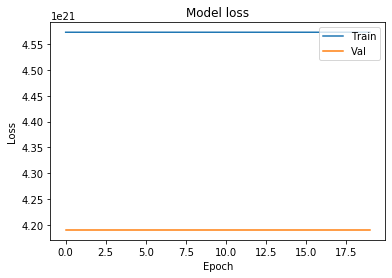

In [41]:
from keras.models import Sequential
from keras.layers import Dense
from keras.layers import Dropout

X_train, X_val_and_test, y_train, y_val_and_test = train_test_split(Train_x, Train_y, test_size=0.2)
X_val, X_test, y_val, y_test = train_test_split(X_val_and_test, y_val_and_test, test_size=0.5)

model = Sequential([
    Dense(40, activation='relu', input_shape=(5,)),
    Dropout(0.2),
    Dense(200, activation='relu'),
    Dropout(0.2),
    Dense(20, activation='sigmoid'),
])

model.compile(loss="mean_squared_error", optimizer='sgd', metrics=['accuracy'])
#model.compile(loss='sparse_categorical_crossentropy', optimizer='adam', metrics=['accuracy'])

hist = model.fit(X_train, y_train,
          batch_size=32, epochs=20,
          validation_data=(X_val, y_val))

model.evaluate(X_test, y_test)[1]

plt.plot(hist.history['loss'])
plt.plot(hist.history['val_loss'])
plt.title('Model loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train', 'Val'], loc='upper right')
plt.show()

In [23]:
print(X_train.shape, X_val.shape, X_test.shape, y_train.shape, y_val.shape, y_test.shape)


(6820, 5) (852, 5) (853, 5) (6820, 1) (852, 1) (853, 1)


In [26]:
dfTrain.corr()

,house_type,price,year,living_space,city
house_type,1.000000,-0.082619,-0.551951,0.289775,-0.031467
price,-0.082619,1.000000,0.191510,0.168573,0.076331
year,-0.551951,0.191510,1.000000,-0.111195,-0.072860
living_space,0.289775,0.168573,-0.111195,1.000000,0.015028
city,-0.031467,0.076331,-0.072860,0.015028,1.000000


In [189]:
!git add "etuovi_scraper-all.py"

In [190]:
!git commit -m "data from all over Finland"

[master 86df6ab] data from all over Finland
 2 files changed, 9043 insertions(+)
 create mode 100644 etuovi_scraper-all.py
 create mode 100644 out2.json


## Toimeenpano

In [15]:
d={'Address': ["Lindforsinkatu 17"], 'City':["Tampere"]}
dist = pd.DataFrame(data=d)

dist['Address_geo'] = dist['Address'] + ", " + dist['City'] + ", Finland"

dist['Address_loc'] = dist['Address_geo'].apply(geolocator.geocode)
# select koordinates from loc
dist['Address_point'] = dist['Address_loc'].apply(lambda loc: tuple(loc.point) if loc else None)
#split coordinates to latitude, longitude and altitude
dist[['lat', 'lon', 'altitude']] = pd.DataFrame(dist['Address_point'].to_list(), index=df.index)

In [16]:
Distance = 10

In [23]:
import haversine as hs
from haversine import Unit
import folium
from folium.plugins import MarkerCluster

In [18]:
print(dist['lat'][0], dist['lon'][0])
print(df['lat'][0], df['lon'][0])

61.44706565 23.838184896329842
60.5508547 22.31609524144914


In [19]:
#Define coordinates of where we want to center our map
center = (dist['lat'][0], dist['lon'][0])

#Create the map
my_map = folium.Map(location = center, zoom_start = 10)

# Add addresses to the map
for index, row in df.iterrows():
    if hs.haversine(center,(row['lat'],row['lon']))<Distance:
        if row.point != None:
            text ="Price: " + str(row.price) + " €" + "\n Size: " + str(row['size']) + " m2 " + "Address: " + row.address
            folium.Marker([row.lat,row.lon], popup = text).add_to(my_map)

#Display the map
my_map


#To calculate distance in meters 
#hs.haversine(loc1,loc2,unit=Unit.METERS)

In [59]:
!git commit -m "Distance from the selected address added"

[master ba0cc17] Distance from the selected address added
 1 file changed, 158 insertions(+), 83 deletions(-)


In [60]:
!git pull

Removing Joda_oppimispaivakirja.ipynb
hint: Waiting for your editor to close the file... error: cannot run editor: No such file or directory
error: unable to start editor 'editor'
Not committing merge; use 'git commit' to complete the merge.


In [61]:
!git commit

hint: Waiting for your editor to close the file... error: cannot run editor: No such file or directory
error: unable to start editor 'editor'
Please supply the message using either -m or -F option.


In [20]:
from __future__ import print_function
from ipywidgets import interact, interactive, fixed, interact_manual
import ipywidgets as widgets

In [25]:
#df.to_json(r'preprosessed_data.json')

In [ ]:

interact(f, Address=widgets.Combobox(options=["Chicago", "New York", "Washington"], value="Chicago"));
#alasvetovalikko
interact(f, City=['apples','oranges']);
#liukuvalikko
interact(f, x=(0,8,2));


In [24]:
@interact
def show_houses(Distance=(0,2000,10), City = 'Tampere', Address = 'Lindforsinkatu 17'):
    d={'Address': [Address], 'City':[City]}
    dist = pd.DataFrame(data=d)

    dist['Address_geo'] = dist['Address'] + ", " + dist['City'] + ", Finland"

    dist['Address_loc'] = dist['Address_geo'].apply(geolocator.geocode)
    # select koordinates from loc
    dist['Address_point'] = dist['Address_loc'].apply(lambda loc: tuple(loc.point) if loc else None)
    #split coordinates to latitude, longitude and altitude
    dist[['lat', 'lon', 'altitude']] = pd.DataFrame(dist['Address_point'].to_list(), index=df.index)
    
    center = (dist['lat'][0], dist['lon'][0])

    #Create the map
    my_map = folium.Map(location = center, zoom_start = 10)

    # Add addresses to the map
    for index, row in df.iterrows():
        if hs.haversine(center,(row['lat'],row['lon']))<Distance:
            if row.point != None:
                text ="Price: " + str(row.price) + " €" + "\n Size: " + str(row['size']) + " m2 " + "Address: " + row.address
                folium.Marker([row.lat,row.lon], popup = text).add_to(my_map)
    
    return my_map

interactive(children=(IntSlider(value=1000, description='Distance', max=2000, step=10), Text(value='Tampere', …

In [ ]:
!git add ""